In [1]:
import transformers
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, cohen_kappa_score
from sklearn.metrics import confusion_matrix
import pandas as pd
import torch
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from datasets import load_dataset
from transformers import TrainingArguments, Trainer, AutoModelForSequenceClassification, AutoModel, AdamW
from transformers import AutoTokenizer
#import regex as re
from collections import defaultdict
from IPython.display import display, HTML, clear_output
from matplotlib import pyplot as plt
import csv
# from bs4 import BeautifulSoup
import re
import base64
import numpy as np
import os
import seaborn as sns

/home/rezett/miniconda3/envs/bert-env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Setting up the device for GPU usage

from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'
print(device)

cuda


In [3]:
# Define the mapping from emotion names to numbers
emotion_mapping = {
    'admiration': 0, 'anger': 1, 'caring': 2, 'confusion': 3, 'curiosity': 4,
    'desire': 5, 'excitement': 6, 'fear': 7, 'gratitude': 8,
    'joy': 9, 'relief': 10, 'sadness': 11,
    'surprise': 12, 'neutral': 13
}

def process_csv(file_path):
    """Processes a single CSV file."""
    df = pd.read_csv(file_path, delimiter=',')

    # Find emotion numbers (same as your existing code)
    emotion_numbers = []
    for index, row in df.iterrows():
        emotion_number = 0
        for emotion, number in emotion_mapping.items():
            if row['emotion'] == emotion:
                emotion_number = number
                break
        emotion_numbers.append(emotion_number)

    # Add emotion numbers as a new column
    df['emotion'] = emotion_numbers

    # Select relevant columns and ensure data types
    new_df = df[['text', 'emotion']]
    new_df['text'] = new_df['text'].astype(str)
    new_df['emotion'] = new_df['emotion'].astype(int)

    return new_df

emotion_data_df = process_csv('./AnnotatedEmails/emotion_aug_data.csv')

/tmp/ipykernel_91236/4080986320.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['text'] = new_df['text'].astype(str)
/tmp/ipykernel_91236/4080986320.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['emotion'] = new_df['emotion'].astype(int)


In [4]:
emotion_data_df.head()

,text,emotion
0,We've noticed a suspicious login attempt from ...,7
1,we've noticed notice untrusting a suspicious l...,7
2,we've noticed suspicious attempt from an unrec...,7
3,we've noticed a suspicious login attempt from ...,7
4,an noticed a suspicious login attempt from we'...,7


### Split data into training and testing by stratifying samples

In [5]:
# Perform stratified split on the final DataFrame
training_df, testing_df = train_test_split(
    emotion_data_df, 
    test_size=0.2,  # 20% of the data is used for testing
    stratify=emotion_data_df['emotion'],  # Stratify by the 'emotion' label
    random_state=42  # Ensure reproducibility
)

# Check the distribution in the original and split datasets
print("Original dataset distribution:\n", emotion_data_df['emotion'].value_counts(normalize=True))
print('\n20%-sample distribution:\n', testing_df['emotion'].value_counts(normalize=True))
print("\n80%-sample distribution:\n", training_df['emotion'].value_counts(normalize=True))

print(training_df.shape)
print(testing_df.shape)

Original dataset distribution:
 emotion
4     0.205945
9     0.171975
11    0.121019
7     0.112527
8     0.108280
10    0.061571
6     0.057325
3     0.055202
12    0.044586
1     0.019108
5     0.019108
2     0.010616
13    0.006369
0     0.006369
Name: proportion, dtype: float64

20%-sample distribution:
 emotion
4     0.205945
9     0.171975
11    0.121019
7     0.112527
8     0.108280
10    0.061571
6     0.057325
3     0.055202
12    0.044586
5     0.019108
1     0.019108
2     0.010616
0     0.006369
13    0.006369
Name: proportion, dtype: float64

80%-sample distribution:
 emotion
4     0.205945
9     0.171975
11    0.121019
7     0.112527
8     0.108280
10    0.061571
6     0.057325
3     0.055202
12    0.044586
1     0.019108
5     0.019108
2     0.010616
0     0.006369
13    0.006369
Name: proportion, dtype: float64
(1884, 2)
(471, 2)


In [ ]:
# Defining some key variables that will be used later on in the training
MAX_LEN = 256
TRAIN_BATCH_SIZE = 16
VALID_BATCH_SIZE = 16
# EPOCHS = 1
LEARNING_RATE =4e-05

# Load pre-trained RoBERTa
model_name = "SamLowe/roberta-base-go_emotions"
tokenizer = transformers.AutoTokenizer.from_pretrained(model_name)
# model = transformers.AutoModelForSequenceClassification.from_pretrained(model_name)

/home/rezett/miniconda3/envs/bert-env/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


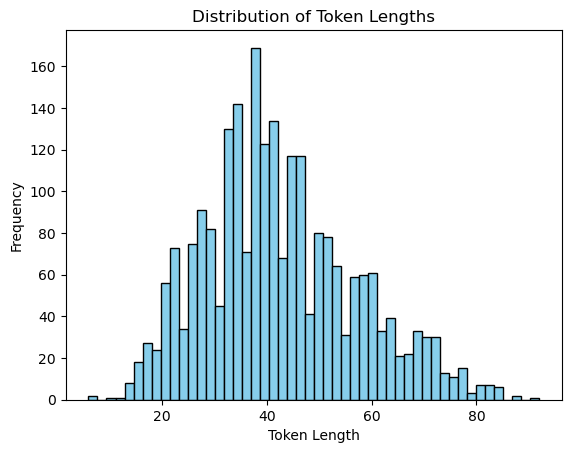

In [7]:
df_emotion_len = pd.DataFrame

# Tokenize messages and calculate lengths for both phishing and ham datasets
df_emotion_len = emotion_data_df['text'].apply(lambda x: len(tokenizer.tokenize(x)))

# Plot the distribution of token lengths
plt.hist(df_emotion_len, bins=50, color='skyblue', edgecolor='black')
plt.xlabel('Token Length')
plt.ylabel('Frequency')
plt.title('Distribution of Token Lengths')
plt.show()

In [8]:
# Calculate descriptive statistics
mean_length = df_emotion_len.mean()
median_length = df_emotion_len.median()
mode_length = df_emotion_len.mode()[0]

print(f"Mean token length: {mean_length}")
print(f"Median token length: {median_length}")
print(f"Mode token length: {mode_length}")

Mean token length: 42.390658174097666
Median token length: 41.0
Mode token length: 38


In [9]:
class SentimentData(Dataset):
    def __init__(self, dataframe, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.text = dataframe.text
        self.targets = self.data.emotion
        self.max_len = max_len

    def __len__(self):
        return len(self.text)

    def __getitem__(self, index):
        text = str(self.text[index])
        text = " ".join(text.split())

        inputs = self.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            return_token_type_ids=True,
            truncation=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]


        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'targets': torch.tensor(self.targets.iloc[index], dtype=torch.long)
        }


In [10]:
train_data = training_df.reset_index(drop=True)
test_data = testing_df.reset_index(drop=True)
training_set = SentimentData(train_data, tokenizer, MAX_LEN)
testing_set = SentimentData(test_data, tokenizer, MAX_LEN)

In [11]:
train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

test_params = {'batch_size': VALID_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

training_loader = DataLoader(training_set, **train_params)
testing_loader = DataLoader(testing_set, **test_params)

In [12]:
class RobertaEmotionsClass(torch.nn.Module):
    def __init__(self):
        super(RobertaEmotionsClass, self).__init__()
        self.model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=14, ignore_mismatched_sizes=True)

    def forward(self, input_ids, attention_mask, token_type_ids):
        outputs = self.model(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        return outputs.logits

In [13]:
print("MODEL NAME {}".format(model_name))
model = RobertaEmotionsClass()
model.to(device)

MODEL NAME SamLowe/roberta-base-go_emotions


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at SamLowe/roberta-base-go_emotions and are newly initialized because the shapes did not match:
- classifier.out_proj.bias: found shape torch.Size([28]) in the checkpoint and torch.Size([14]) in the model instantiated
- classifier.out_proj.weight: found shape torch.Size([28, 768]) in the checkpoint and torch.Size([14, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RobertaEmotionsClass(
  (model): RobertaForSequenceClassification(
    (roberta): RobertaModel(
      (embeddings): RobertaEmbeddings(
        (word_embeddings): Embedding(50265, 768, padding_idx=1)
        (position_embeddings): Embedding(514, 768, padding_idx=1)
        (token_type_embeddings): Embedding(1, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): RobertaEncoder(
        (layer): ModuleList(
          (0-11): 12 x RobertaLayer(
            (attention): RobertaAttention(
              (self): RobertaSdpaSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (output): RobertaSelfOutput(
              

In [14]:
# Creating the loss function and optimizer
loss_function = torch.nn.CrossEntropyLoss()
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=0.0001)

/home/rezett/miniconda3/envs/bert-env/lib/python3.11/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [15]:
def calcuate_accuracy(preds, targets):
    n_correct = (preds==targets).sum().item()
    return n_correct

def train(epoch):
    tr_loss = 0
    n_correct = 0
    nb_tr_steps = 0
    nb_tr_examples = 0
    model.train()
    for _,data in tqdm(enumerate(training_loader, 0)):
        ids = data['ids'].to(device, dtype = torch.long)
        mask = data['mask'].to(device, dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        targets = data['targets'].to(device, dtype = torch.long)

        optimizer.zero_grad()
        outputs = model(ids, mask, token_type_ids)
        loss = loss_function(outputs, targets)
        tr_loss += loss.item()
        big_val, big_idx = torch.max(outputs.data, dim=1)
        n_correct += calcuate_accuracy(big_idx, targets)

        nb_tr_steps += 1
        nb_tr_examples+=targets.size(0)

        if _%5000==0:
            loss_step = tr_loss/nb_tr_steps
            accu_step = (n_correct*100)/nb_tr_examples
            print(f"Training Loss per 5000 steps: {loss_step}")
            print(f"Training Accuracy per 5000 steps: {accu_step}")

        #optimizer.zero_grad()
        loss.backward()
        # # When using GPU
        optimizer.step()

    print(f'The Total Accuracy for Epoch {epoch}: {(n_correct*100)/nb_tr_examples}')
    epoch_loss = tr_loss/nb_tr_steps
    epoch_accu = (n_correct*100)/nb_tr_examples
    print(f"Training Loss Epoch: {epoch_loss}")
    print(f"Training Accuracy Epoch: {epoch_accu}")

    return epoch_accu, epoch_loss

In [16]:
def valid(model, testing_loader):
    model.eval()
    n_correct = 0; n_wrong = 0; total = 0; tr_loss=0; nb_tr_steps=0; nb_tr_examples=0
    all_targets = []  # To store all true labels
    all_predictions = []  # To store all predictions
    with torch.no_grad():
        for _, data in tqdm(enumerate(testing_loader, 0)):
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype=torch.long)
            targets = data['targets'].to(device, dtype = torch.long)
            outputs = model(ids, mask, token_type_ids).squeeze()
            loss = loss_function(outputs, targets)
            tr_loss += loss.item()
            big_val, big_idx = torch.max(outputs.data, dim=1)

            # Store predictions and targets for confusion matrix
            all_targets.extend(targets.cpu().numpy())
            all_predictions.extend(big_idx.cpu().numpy())

            n_correct += calcuate_accuracy(big_idx, targets)

            nb_tr_steps += 1
            nb_tr_examples+=targets.size(0)
            
            if _%5000==0:
                loss_step = tr_loss/nb_tr_steps
                accu_step = (n_correct*100)/nb_tr_examples
                print(f"Validation Loss per 100 steps: {loss_step}")
                print(f"Validation Accuracy per 100 steps: {accu_step}")

    epoch_loss = tr_loss/nb_tr_steps
    epoch_accu = (n_correct*100)/nb_tr_examples
    print(f"Validation Loss Epoch: {epoch_loss}")
    print(f"Validation Accuracy Epoch: {epoch_accu}")
    
    return epoch_accu, epoch_loss, all_targets, all_predictions

In [17]:
EPOCHS = 10
train_accuracies = []  # To store training accuracy for each epoch
validation_accuracies = []  # To store validation accuracy for each epoch
train_losses = []  # List to store training loss for each epoch
validation_losses = []  # List to store validation loss for each epoch
best_accuracy = 0  # Initialize best validation accuracy

for epoch in range(EPOCHS):
    print(f"Epoch {epoch + 1}/{EPOCHS}")

    # Training phase 
    train_accuracy, train_loss = train(epoch)  
    train_accuracies.append(train_accuracy)
    train_losses.append(train_loss)

    # Validation phase
    validation_accuracy, validation_loss, _, __ = valid(model, testing_loader)
    validation_accuracies.append(validation_accuracy)
    validation_losses.append(validation_loss)

    # Save the model if validation accuracy is the best so far
    if validation_accuracy > best_accuracy:
        best_accuracy = validation_accuracy
        print(f"Saving model with validation accuracy: {best_accuracy}")
        torch.save(model.state_dict(), f"./Models/test_reddit_roberta/{LEARNING_RATE}_roberta_model_epoch_{epoch + 1}.pth")  # Save best model

Epoch 1/10


0it [00:00, ?it/s]

Training Loss per 5000 steps: 2.5220885276794434
Training Accuracy per 5000 steps: 6.25


118it [00:35,  3.30it/s]


The Total Accuracy for Epoch 0: 65.12738853503184
Training Loss Epoch: 1.1978018796544965
Training Accuracy Epoch: 65.12738853503184


2it [00:00,  5.91it/s]

Validation Loss per 100 steps: 1.029358148574829
Validation Accuracy per 100 steps: 56.25


30it [00:03,  8.61it/s]


Validation Loss Epoch: 0.7069999814033509
Validation Accuracy Epoch: 76.2208067940552
Saving model with validation accuracy: 76.2208067940552
Epoch 2/10


1it [00:00,  6.78it/s]

Training Loss per 5000 steps: 1.18458092212677
Training Accuracy per 5000 steps: 50.0


118it [00:37,  3.18it/s]


The Total Accuracy for Epoch 1: 84.28874734607218
Training Loss Epoch: 0.4957245405826528
Training Accuracy Epoch: 84.28874734607218


2it [00:00,  5.82it/s]

Validation Loss per 100 steps: 0.7356544733047485
Validation Accuracy per 100 steps: 75.0


30it [00:03,  8.15it/s]


Validation Loss Epoch: 0.40306939544777076
Validation Accuracy Epoch: 85.77494692144374
Saving model with validation accuracy: 85.77494692144374
Epoch 3/10


1it [00:00,  5.91it/s]

Training Loss per 5000 steps: 0.4372170567512512
Training Accuracy per 5000 steps: 81.25


118it [00:38,  3.09it/s]


The Total Accuracy for Epoch 2: 91.02972399150742
Training Loss Epoch: 0.2783993331526043
Training Accuracy Epoch: 91.02972399150742


2it [00:00,  5.70it/s]

Validation Loss per 100 steps: 0.4207478165626526
Validation Accuracy per 100 steps: 87.5


30it [00:03,  8.20it/s]


Validation Loss Epoch: 0.3381682185456157
Validation Accuracy Epoch: 88.1104033970276
Saving model with validation accuracy: 88.1104033970276
Epoch 4/10


0it [00:00, ?it/s]

Training Loss per 5000 steps: 0.3195890188217163
Training Accuracy per 5000 steps: 87.5


118it [00:35,  3.30it/s]


The Total Accuracy for Epoch 3: 93.5244161358811
Training Loss Epoch: 0.20381935621154004
Training Accuracy Epoch: 93.5244161358811


2it [00:00,  5.83it/s]

Validation Loss per 100 steps: 0.3277290463447571
Validation Accuracy per 100 steps: 93.75


30it [00:03,  8.57it/s]


Validation Loss Epoch: 0.20811946730439862
Validation Accuracy Epoch: 93.63057324840764
Saving model with validation accuracy: 93.63057324840764
Epoch 5/10


1it [00:00,  6.58it/s]

Training Loss per 5000 steps: 0.19685539603233337
Training Accuracy per 5000 steps: 87.5


118it [00:40,  2.91it/s]


The Total Accuracy for Epoch 4: 96.97452229299363
Training Loss Epoch: 0.1132640901842486
Training Accuracy Epoch: 96.97452229299363


3it [00:00,  7.74it/s]

Validation Loss per 100 steps: 0.5736628770828247
Validation Accuracy per 100 steps: 87.5


30it [00:02, 10.22it/s]


Validation Loss Epoch: 0.25023219765474397
Validation Accuracy Epoch: 94.0552016985138
Saving model with validation accuracy: 94.0552016985138
Epoch 6/10


1it [00:00,  6.83it/s]

Training Loss per 5000 steps: 0.025101512670516968
Training Accuracy per 5000 steps: 100.0


118it [00:37,  3.16it/s]


The Total Accuracy for Epoch 5: 97.82377919320595
Training Loss Epoch: 0.0833509707491908
Training Accuracy Epoch: 97.82377919320595


3it [00:00,  7.47it/s]

Validation Loss per 100 steps: 0.0955018624663353
Validation Accuracy per 100 steps: 93.75


30it [00:01, 19.96it/s]


Validation Loss Epoch: 0.23591037935887774
Validation Accuracy Epoch: 91.93205944798301
Epoch 7/10


1it [00:00,  7.50it/s]

Training Loss per 5000 steps: 0.14612272381782532
Training Accuracy per 5000 steps: 93.75


118it [00:34,  3.40it/s]


The Total Accuracy for Epoch 6: 97.87685774946921
Training Loss Epoch: 0.075224192157956
Training Accuracy Epoch: 97.87685774946921


3it [00:00,  7.93it/s]

Validation Loss per 100 steps: 0.13725699484348297
Validation Accuracy per 100 steps: 87.5


30it [00:02, 10.21it/s]


Validation Loss Epoch: 0.19848840696116288
Validation Accuracy Epoch: 94.90445859872611
Saving model with validation accuracy: 94.90445859872611
Epoch 8/10


1it [00:00,  7.43it/s]

Training Loss per 5000 steps: 0.06258943676948547
Training Accuracy per 5000 steps: 93.75


118it [00:36,  3.27it/s]


The Total Accuracy for Epoch 7: 97.66454352441613
Training Loss Epoch: 0.0730270187970314
Training Accuracy Epoch: 97.66454352441613


2it [00:00,  5.76it/s]

Validation Loss per 100 steps: 0.014500570483505726
Validation Accuracy per 100 steps: 100.0


30it [00:03,  9.88it/s]


Validation Loss Epoch: 0.19519483139738442
Validation Accuracy Epoch: 95.32908704883228
Saving model with validation accuracy: 95.32908704883228
Epoch 9/10


1it [00:00,  7.39it/s]

Training Loss per 5000 steps: 0.03755111247301102
Training Accuracy per 5000 steps: 100.0


118it [00:34,  3.39it/s]


The Total Accuracy for Epoch 8: 98.19532908704883
Training Loss Epoch: 0.06833786201284472
Training Accuracy Epoch: 98.19532908704883


3it [00:00,  7.66it/s]

Validation Loss per 100 steps: 0.35813790559768677
Validation Accuracy per 100 steps: 93.75


30it [00:03,  9.17it/s]


Validation Loss Epoch: 0.1832256309532871
Validation Accuracy Epoch: 95.96602972399151
Saving model with validation accuracy: 95.96602972399151
Epoch 10/10


1it [00:00,  7.28it/s]

Training Loss per 5000 steps: 0.00518794683739543
Training Accuracy per 5000 steps: 100.0


118it [00:34,  3.37it/s]


The Total Accuracy for Epoch 9: 97.87685774946921
Training Loss Epoch: 0.07603145550573402
Training Accuracy Epoch: 97.87685774946921


3it [00:00,  7.66it/s]

Validation Loss per 100 steps: 0.021469634026288986
Validation Accuracy per 100 steps: 100.0


30it [00:03,  9.94it/s]

Validation Loss Epoch: 0.31325559923425317
Validation Accuracy Epoch: 93.63057324840764


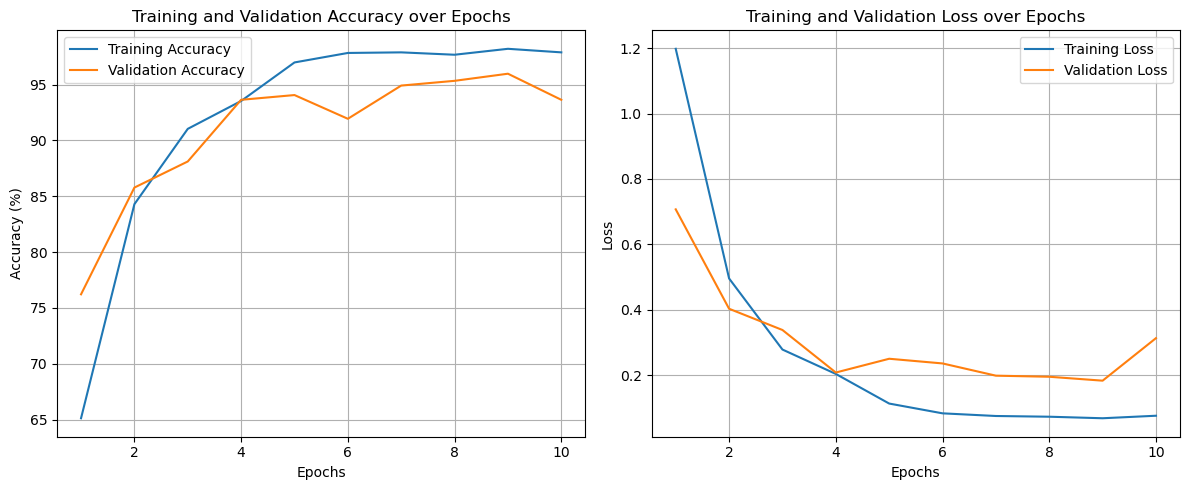

In [18]:
# Plotting the accuracy vs epochs
epochs_range = range(1, EPOCHS + 1)
plt.figure(figsize=(12, 5))

# Plotting Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_accuracies, label='Training Accuracy')
plt.plot(epochs_range, validation_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy over Epochs')
plt.legend()
plt.grid(True)

# Plotting Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_losses, label='Training Loss')
plt.plot(epochs_range, validation_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

2it [00:00,  9.11it/s]

Validation Loss per 100 steps: 1.0897839069366455
Validation Accuracy per 100 steps: 81.25


30it [00:03,  8.78it/s]


Validation Loss Epoch: 0.3436429049664487
Validation Accuracy Epoch: 93.63057324840764
Validation Accuracy: 0.94
Validation Precision: 0.94
Validation Recall: 0.94
Validation F1 Score: 0.93
Classification Report:
              precision    recall  f1-score   support

  admiration       1.00      1.00      1.00         3
       anger       1.00      0.56      0.71         9
      caring       1.00      1.00      1.00         5
   confusion       1.00      0.96      0.98        26
   curiosity       0.93      0.96      0.94        97
      desire       1.00      0.44      0.62         9
  excitement       0.92      0.89      0.91        27
        fear       0.91      1.00      0.95        53
   gratitude       0.98      0.86      0.92        51
         joy       0.92      0.99      0.95        81
      relief       0.92      0.83      0.87        29
     sadness       0.97      1.00      0.98        57
    surprise       0.84      1.00      0.91        21
     neutral       1.00      1

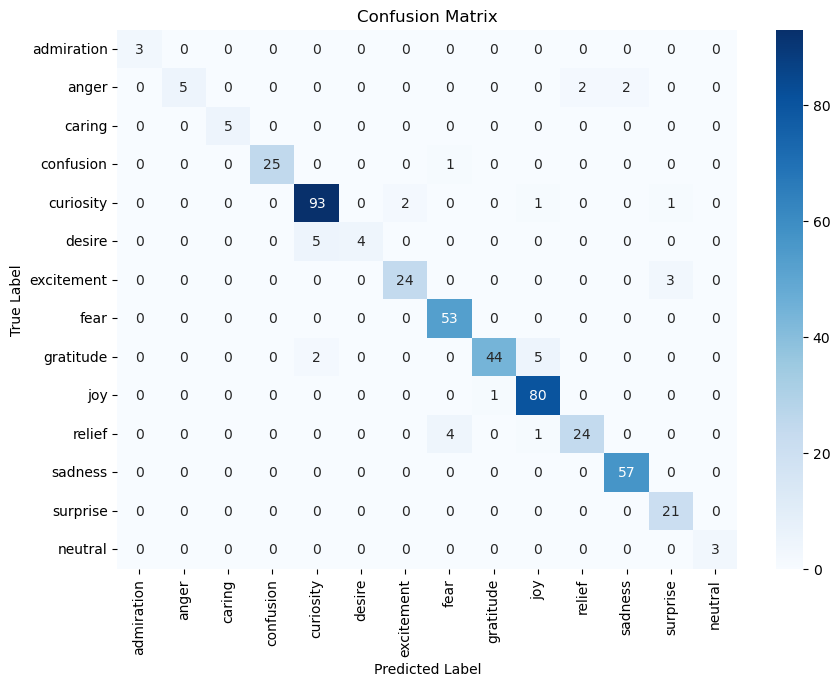

In [19]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, precision_score, recall_score, f1_score


# Validation phase with confusion matrix
validation_accuracy, validation_loss, all_targets, all_predictions = valid(model, testing_loader)

# Generate a confusion matrix
cm = confusion_matrix(all_targets, all_predictions)

def plot_confusion_matrix(cm, class_names):
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

# Reverse the mapping dictionary to get encoded value as key and label as value
reversed_label_map = {v: k for k, v in emotion_mapping.items()}

# Get the count of each emotion label
testing_df['emotion_label'] = testing_df['emotion'].map(reversed_label_map)
emotion_counts = testing_df['emotion_label'].value_counts()

# Get the count of each emotion label
# Map the encoded labels back to emotion labels
training_df['emotion_label'] = training_df['emotion'].map(reversed_label_map)
emotion_counts = training_df['emotion_label'].value_counts()

# Get the unique values from the 'emotion' column
unique_emotions = emotion_data_df['emotion'].unique()

# Get the actual class names using the reversed mapping
class_names = [reversed_label_map[emotion] for emotion in sorted(unique_emotions)]

# Get the accuracy
accuracy = accuracy_score(all_targets, all_predictions)
precision_score = precision_score(all_targets, all_predictions, average='weighted')
recall_score = recall_score(all_targets, all_predictions, average='weighted')
f1_score = f1_score(all_targets, all_predictions, average='weighted')
print(f"Validation Accuracy: {accuracy:.2f}")
print(f"Validation Precision: {precision_score:.2f}")
print(f"Validation Recall: {recall_score:.2f}")
print(f"Validation F1 Score: {f1_score:.2f}")

# Generate a classification report with precision, recall, f1-score for each label
class_report = classification_report(all_targets, all_predictions, target_names=class_names)
print("Classification Report:")
print(class_report)

plot_confusion_matrix(cm, class_names)